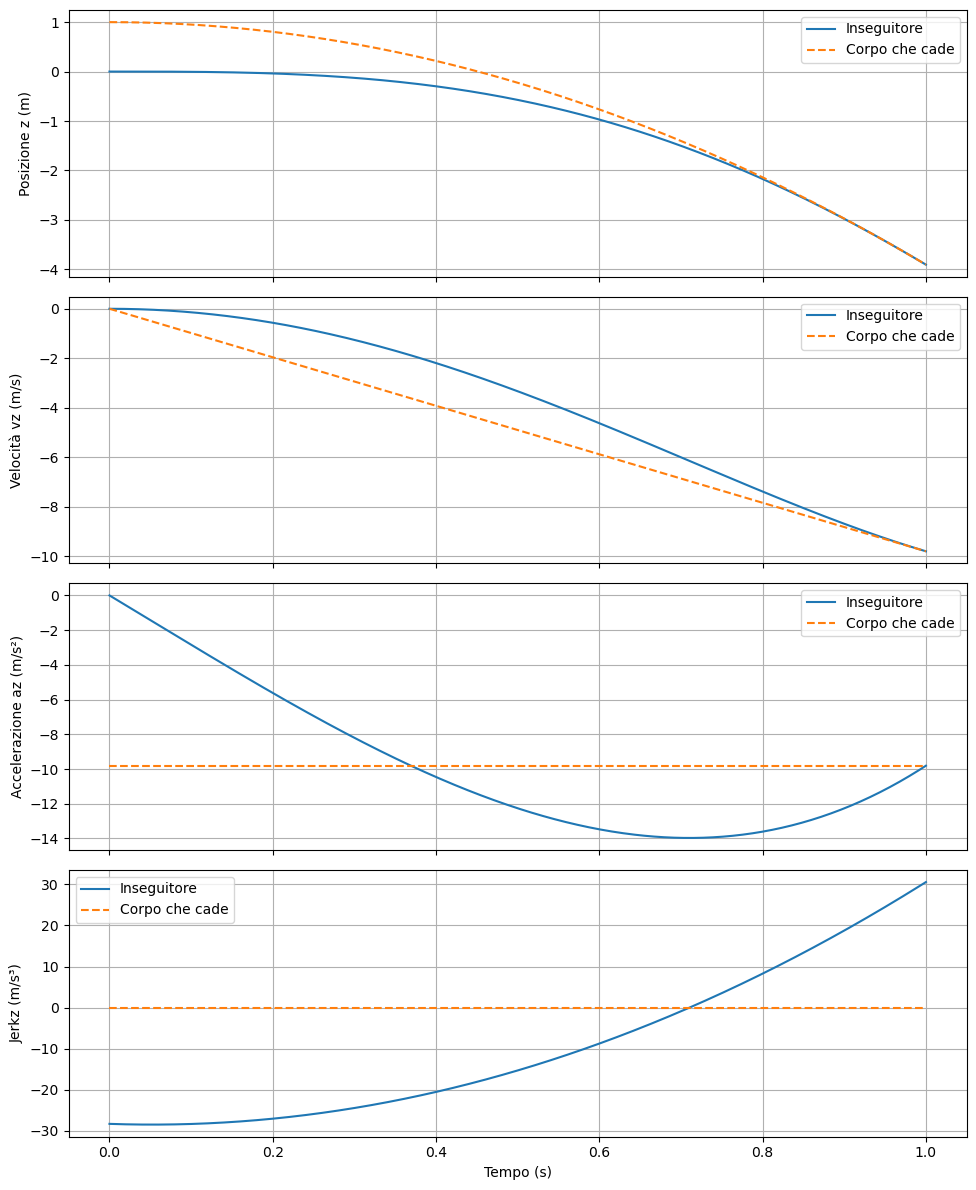

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Dati iniziali
z0 = 0      # posizione iniziale inseguitore
vz0 = 0      # velocità iniziale inseguitore
az0 = 0      # accelerazione iniziale inseguitore

zc0 = 1     # posizione iniziale corpo che cade
vc0 = 0      # velocità iniziale corpo che cade
ac0 = -9.81  # accelerazione gravitazionale (m/s²)

tf = 1      # tempo finale per intercettare

# Stato finale del corpo che cade
zcf = zc0 + vc0*tf + 0.5*ac0*tf**2
vcf = vc0 + ac0*tf
acf = ac0

# Sistema lineare per determinare i coefficienti del polinomio quintico
T = tf
A = np.array([
    [1,    0,     0,     0,      0,       0     ],
    [0,    1,     0,     0,      0,       0     ],
    [0,    0,     2,     0,      0,       0     ],
    [1,    T,     T**2,  T**3,   T**4,    T**5  ],
    [0,    1,     2*T,   3*T**2, 4*T**3,  5*T**4],
    [0,    0,     2,     6*T,   12*T**2, 20*T**3]
])
b = np.array([z0, vz0, az0, zcf, vcf, acf])
coeffs = np.linalg.solve(A, b)

# Tempo
t = np.linspace(0, tf, 500)

# Traiettoria inseguitore
z = np.polyval(coeffs[::-1], t)
vz = np.polyval(np.polyder(coeffs[::-1], 1), t)
az = np.polyval(np.polyder(coeffs[::-1], 2), t)
jz = np.polyval(np.polyder(coeffs[::-1], 3), t)

# Traiettoria del corpo che cade
zc = zc0 + vc0 * t + 0.5 * ac0 * t**2
vzc = vc0 + ac0 * t
azc = np.full_like(t, ac0)
jzc = np.zeros_like(t)

# Plot
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

axs[0].plot(t, z, label='Inseguitore')
axs[0].plot(t, zc, '--', label='Corpo che cade')
axs[0].set_ylabel('Posizione z (m)')
axs[0].legend()
axs[0].grid()

axs[1].plot(t, vz, label='Inseguitore')
axs[1].plot(t, vzc, '--', label='Corpo che cade')
axs[1].set_ylabel('Velocità vz (m/s)')
axs[1].legend()
axs[1].grid()

axs[2].plot(t, az, label='Inseguitore')
axs[2].plot(t, azc, '--', label='Corpo che cade')
axs[2].set_ylabel('Accelerazione az (m/s²)')
axs[2].legend()
axs[2].grid()

axs[3].plot(t, jz, label='Inseguitore')
axs[3].plot(t, jzc, '--', label='Corpo che cade')
axs[3].set_ylabel('Jerkz (m/s³)')
axs[3].set_xlabel('Tempo (s)')
axs[3].legend()
axs[3].grid()

plt.tight_layout()
plt.show()


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 10954.766965800089
            Iterations: 42
            Function evaluations: 171
            Gradient evaluations: 38
Optimized times: t1 = 3.877 s, t2 = 3.866 s


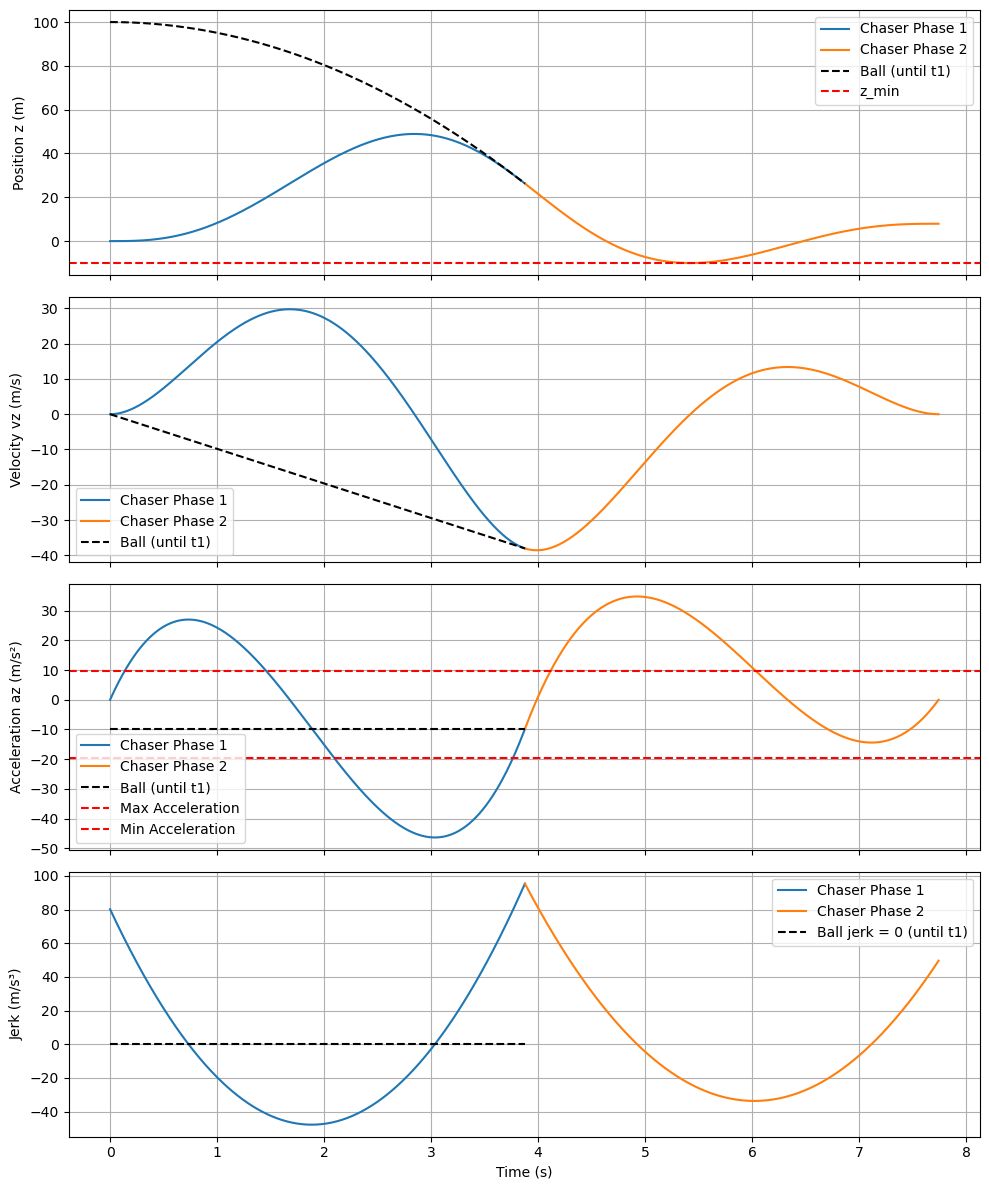

In [129]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- Polynomial coefficient functions (same as before) ---
def compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1):
    T = t1
    zcf = zc0 + vc0*T + 0.5*ac0*T**2
    vcf = vc0 + ac0*T
    acf = ac0
    A = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0],
        [1, T, T**2, T**3, T**4, T**5],
        [0, 1, 2*T, 3*T**2, 4*T**3, 5*T**4],
        [0, 0, 2, 6*T, 12*T**2, 20*T**3]
    ])
    b = np.array([z0, vz0, az0, zcf, vcf, acf])
    return np.linalg.solve(A, b)

def compute_coeffs_phase2(coeffs1, t1, t2):
    coeffs1_rev = coeffs1[::-1]
    j_poly = np.polyder(coeffs1_rev, 3)
    j_end = np.polyval(j_poly, t1)
    z_end = np.polyval(coeffs1_rev, t1)
    vz_end = np.polyval(np.polyder(coeffs1_rev, 1), t1)
    az_end = np.polyval(np.polyder(coeffs1_rev, 2), t1)
    T = t2
    A = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0],
        [0, 0, 0, 6, 0, 0],
        [0, 1, 2*T, 3*T**2, 4*T**3, 5*T**4],
        [0, 0, 2, 6*T, 12*T**2, 20*T**3]
    ])
    b = np.array([z_end, vz_end, az_end, j_end, 0, 0])
    return np.linalg.solve(A, b)

# --- Constraints helper functions ---
def make_acc_upper_constraint(phase, idx, z0, vz0, az0, zc0, vc0, ac0, N, limit=9.81):
    def constraint(x):
        t1, t2 = x
        if t1 <= 0 or t2 <= 0:
            return -1e12
        if phase == 1:
            coeffs = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
            t_vals = np.linspace(0, t1, N)
        else:
            coeffs1 = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
            coeffs = compute_coeffs_phase2(coeffs1, t1, t2)
            t_vals = np.linspace(0, t2, N)
        az = np.polyval(np.polyder(coeffs[::-1], 2), t_vals)
        return limit - az[idx]
    return constraint

def make_acc_lower_constraint(phase, idx, z0, vz0, az0, zc0, vc0, ac0, N, limit=-2*9.81):
    def constraint(x):
        t1, t2 = x
        if t1 <= 0 or t2 <= 0:
            return -1e12
        if phase == 1:
            coeffs = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
            t_vals = np.linspace(0, t1, N)
        else:
            coeffs1 = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
            coeffs = compute_coeffs_phase2(coeffs1, t1, t2)
            t_vals = np.linspace(0, t2, N)
        az = np.polyval(np.polyder(coeffs[::-1], 2), t_vals)
        return az[idx] - limit
    return constraint

def make_pos_constraint(phase, idx, z0, vz0, az0, zc0, vc0, ac0, z_min, N):
    def constraint(x):
        t1, t2 = x
        if t1 <= 0 or t2 <= 0:
            return -1e12
        if phase == 1:
            coeffs = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
            t_vals = np.linspace(0, t1, N)
        else:
            coeffs1 = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
            coeffs = compute_coeffs_phase2(coeffs1, t1, t2)
            t_vals = np.linspace(0, t2, N)
        z = np.polyval(coeffs[::-1], t_vals)
        return z[idx] - z_min
    return constraint


# --- Objective function ---
def objective_with_penalty(x, z0, vz0, az0, zc0, vc0, ac0, z_min, N=50, jerk_weight=1.0):
    t1, t2 = x
    if t1 <= 0 or t2 <= 0:
        return 1e6

    # Phase 1 trajectory
    coeffs1 = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
    t_vals1 = np.linspace(0, t1, N)
    z1 = np.polyval(coeffs1[::-1], t_vals1)
    if np.any(z1 < z_min):
        return 1e6

    jerk1 = np.polyval(np.polyder(coeffs1[::-1], 3), t_vals1)
    jerk_penalty1 = np.trapz(jerk1**2, t_vals1)

    # Phase 2 trajectory
    coeffs2 = compute_coeffs_phase2(coeffs1, t1, t2)
    t_vals2 = np.linspace(0, t2, N)
    z2 = np.polyval(coeffs2[::-1], t_vals2)
    if np.any(z2 < z_min):
        return 1e6

    jerk2 = np.polyval(np.polyder(coeffs2[::-1], 3), t_vals2)
    jerk_penalty2 = np.trapz(jerk2**2, t_vals2)

    # Total objective: time + jerk penalty
    jerk_penalty = jerk_weight * (jerk_penalty1 + jerk_penalty2)
    return jerk_penalty


# --- Main optimization function ---
def optimize_times_nonlinear(z0, vz0, az0, zc0, vc0, ac0, z_min):
    x0 = np.array([2.0, 2.0])  # initial guess
    
    bounds = [(0.1, None), (0.1, None)]  # t1,t2 > 0.1s
    
    N_sample = 100
    
    constraints = []

    for i in range(N_sample):
        constraints.append({
            'type': 'ineq',
            'fun': make_acc_upper_constraint(1, i, z0, vz0, az0, zc0, vc0, ac0, N_sample)
        })
        constraints.append({
            'type': 'ineq',
            'fun': make_acc_lower_constraint(1, i, z0, vz0, az0, zc0, vc0, ac0, N_sample)
        })
        constraints.append({
            'type': 'ineq',
            'fun': make_pos_constraint(1, i, z0, vz0, az0, zc0, vc0, ac0, z_min, N_sample)
        })

    for i in range(N_sample):
        constraints.append({
            'type': 'ineq',
            'fun': make_acc_upper_constraint(2, i, z0, vz0, az0, zc0, vc0, ac0, N_sample)
        })
        constraints.append({
            'type': 'ineq',
            'fun': make_acc_lower_constraint(2, i, z0, vz0, az0, zc0, vc0, ac0, N_sample)
        })
        constraints.append({
            'type': 'ineq',
            'fun': make_pos_constraint(2, i, z0, vz0, az0, zc0, vc0, ac0, z_min, N_sample)
        })

    
    res = minimize(
        objective_with_penalty, 
        x0, 
        args=(z0, vz0, az0, zc0, vc0, ac0, z_min), 
        bounds=bounds, 
        constraints=constraints,
        method='SLSQP', 
        options={
            'disp': True, 
            'maxiter': 500,
            'ftol': 1e-9,   # tighter solution tolerance
            'eps': 1e-6     # finer finite-difference step for better constraint satisfaction
        }
    )
    
    return res.x

# --- Plot function (reuse your existing code) ---
def compute_chaser_trajectory(z0, vz0, az0, zc0, vc0, ac0, t1, t2, z_min, N=500, plot=True):
    coeffs1 = compute_coeffs_phase1(z0, vz0, az0, zc0, vc0, ac0, t1)
    coeffs2 = compute_coeffs_phase2(coeffs1, t1, t2)
    
    t_phase1 = np.linspace(0, t1, N)
    t_phase2 = np.linspace(0, t2, N)
    
    # Ball only up to t1
    t_ball = np.linspace(0, t1, N)
    
    # Chaser phases
    z_phase1 = np.polyval(coeffs1[::-1], t_phase1)
    vz_phase1 = np.polyval(np.polyder(coeffs1[::-1], 1), t_phase1)
    az_phase1 = np.polyval(np.polyder(coeffs1[::-1], 2), t_phase1)
    j_phase1 = np.polyval(np.polyder(coeffs1[::-1], 3), t_phase1)
    
    z_phase2 = np.polyval(coeffs2[::-1], t_phase2)
    vz_phase2 = np.polyval(np.polyder(coeffs2[::-1], 1), t_phase2)
    az_phase2 = np.polyval(np.polyder(coeffs2[::-1], 2), t_phase2)
    j_phase2 = np.polyval(np.polyder(coeffs2[::-1], 3), t_phase2)
    
    # Ball trajectory until t1
    z_ball = zc0 + vc0 * t_ball + 0.5 * ac0 * t_ball**2
    vz_ball = vc0 + ac0 * t_ball
    az_ball = np.full_like(t_ball, ac0)
    
    if plot:
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(t_phase1, z_phase1, label='Chaser Phase 1')
        axs[0].plot(t_phase2 + t1, z_phase2, label='Chaser Phase 2')
        axs[0].plot(t_ball, z_ball, '--', color='k', label='Ball (until t1)')
        axs[0].axhline(z_min, color='r', linestyle='--', label='z_min')
        axs[0].set_ylabel('Position z (m)')
        axs[0].legend()
        axs[0].grid()
        
        axs[1].plot(t_phase1, vz_phase1, label='Chaser Phase 1')
        axs[1].plot(t_phase2 + t1, vz_phase2, label='Chaser Phase 2')
        axs[1].plot(t_ball, vz_ball, '--', color='k', label='Ball (until t1)')
        axs[1].set_ylabel('Velocity vz (m/s)')
        axs[1].legend()
        axs[1].grid()
        
        axs[2].plot(t_phase1, az_phase1, label='Chaser Phase 1')
        axs[2].plot(t_phase2 + t1, az_phase2, label='Chaser Phase 2')
        axs[2].plot(t_ball, az_ball, '--', color='k', label='Ball (until t1)')
        axs[2].axhline(9.81, color='r', linestyle='--', label='Max Acceleration')
        axs[2].axhline(-2*9.81, color='r', linestyle='--', label='Min Acceleration')
        axs[2].set_ylabel('Acceleration az (m/s²)')
        axs[2].legend()
        axs[2].grid()
        
        axs[3].plot(t_phase1, j_phase1, label='Chaser Phase 1')
        axs[3].plot(t_phase2 + t1, j_phase2, label='Chaser Phase 2')
        axs[3].plot(t_ball, np.zeros_like(t_ball), '--', color='k', label='Ball jerk = 0 (until t1)')
        axs[3].set_ylabel('Jerk (m/s³)')
        axs[3].set_xlabel('Time (s)')
        axs[3].legend()
        axs[3].grid()
        
        plt.tight_layout()
        plt.show()

    return {
        't_phase1': t_phase1, 'z_phase1': z_phase1, 'vz_phase1': vz_phase1, 'az_phase1': az_phase1, 'j_phase1': j_phase1,
        't_phase2': t_phase2, 'z_phase2': z_phase2, 'vz_phase2': vz_phase2, 'az_phase2': az_phase2, 'j_phase2': j_phase2,
        't_ball': t_ball, 'z_ball': z_ball, 'vz_ball': vz_ball, 'az_ball': az_ball,
    }

# --- Example usage ---
if __name__ == "__main__":
    z0 = 0
    vz0 = 0
    az0 = 0
    zc0 = 100
    vc0 = 0
    ac0 = -9.81
    z_min = -10
    
    t1_opt, t2_opt = optimize_times_nonlinear(z0, vz0, az0, zc0, vc0, ac0, z_min)
    print(f"Optimized times: t1 = {t1_opt:.3f} s, t2 = {t2_opt:.3f} s")
    
    compute_chaser_trajectory(z0, vz0, az0, zc0, vc0, ac0, t1_opt, t2_opt, z_min)
